# Selección de train y test
En este script intentaremos entender cuales son los datos de train y test que usan para entrenar el modelo nilm, las preguntas que deseamos responder son:

1. ¿Debo entrenar el modelo solo para el dispositivo que deseo desagregar?
2. ¿Que medidores son los que debo usar en el proceso de entrenamiento?
3. ¿Debo solo entregar como entrada la señal del medidor individual?
4. ¿o todos los medidores mas la carga central o general?
5. ¿Para hacer el test debo pasar como entrada la medida central?

In [1]:
#0. Cargar las librerias generales
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline
#Constante para el tamño de las imagenes
rcParams['figure.figsize'] = (13, 6)

In [2]:
#1. Cargar los archivos del programa para dividirlos en train y test
train = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
test = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')

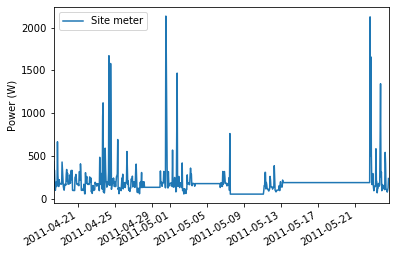

In [3]:
elecs1 = test.buildings[1].elec
main1 = elecs1[1]
main1.plot()

In [4]:
#2. Seleccionamos uno de los edificios para el experimento
building = 1

In [5]:
#3. Especifica peridos de fin para train e inicio para test. Usa el mes de abril
train.set_window(end="2011-04-30")
test.set_window(start="2011-04-30")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


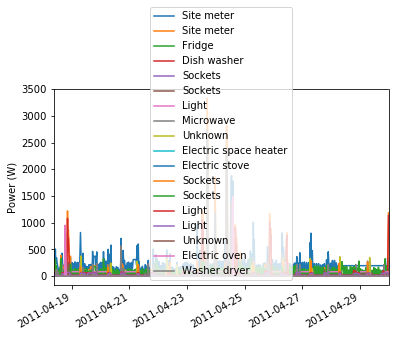

In [7]:
#4. Visualizacion datos de entrenamiento
train_elec.plot()

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


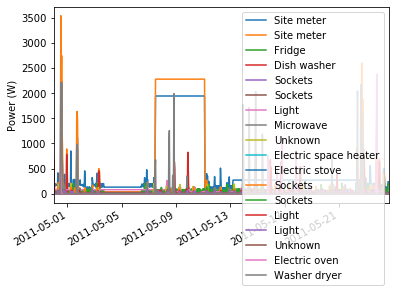

In [7]:
#5. Visualización datos de test
test_elec.plot()

El conjunto de datos REDD tiene datos de nivel de electrodomésticos muestreados cada 3 o 4 segundos y datos de red tomados cada segundo. Comprobemos lo mismo.

In [6]:
#6. Para un medidor disgregado o de dispositivo
fridge_meter = train_elec['fridge']
fridge_df = next(fridge_meter.load())
fridge_df.head()

physical_quantity,power
type,active
2011-04-18 09:22:13-04:00,6.0
2011-04-18 09:22:16-04:00,6.0
2011-04-18 09:22:20-04:00,6.0
2011-04-18 09:22:23-04:00,6.0
2011-04-18 09:22:26-04:00,6.0


In [7]:
#7. Para el medidor central
mains = train_elec.mains()
mains_df = next(mains.load())
mains_df.head()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


physical_quantity,power
type,apparent
2011-04-18 09:22:09-04:00,342.820007
2011-04-18 09:22:10-04:00,344.559998
2011-04-18 09:22:11-04:00,345.140015
2011-04-18 09:22:12-04:00,341.679993
2011-04-18 09:22:13-04:00,341.029999


Dado que ambos se muestrean a diferentes frecuencias, reduciremos la resolución de ambos a una resolución de 1 minuto. La minima resolución es de los medidores disgregados a 3s está es la minima resolución que podemos usar para igualar. 
También seleccionaremos los 5 mejores electrodomésticos en términos de consumo de energía y los usaremos para entrenar nuestros modelos FHMM y CO.

## Selección de los 5 mejores electrodomésticos

In [8]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

In [19]:
top_5_train_elec

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
)

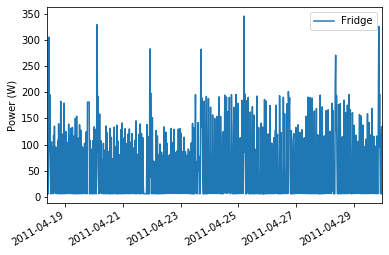

In [20]:
top_5_train_elec[5].plot()

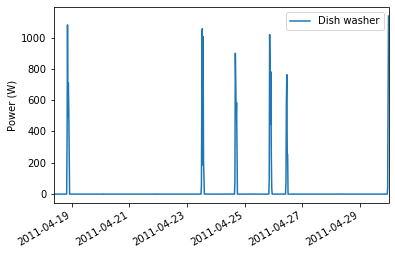

In [21]:
top_5_train_elec[6].plot()

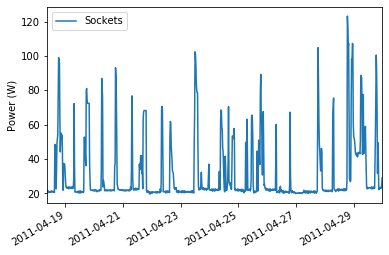

In [22]:
top_5_train_elec[8].plot()

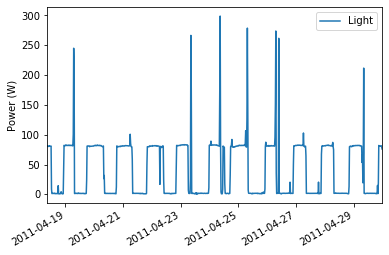

In [23]:
top_5_train_elec[9].plot()

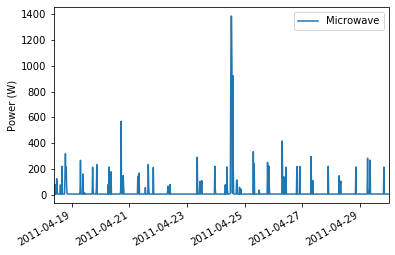

In [24]:
top_5_train_elec[11].plot()

## Capacitación y desagregación
Una función para desagregar los datos de la red a los electrodomésticos constituyentes y devolver las predicciones. 

Los datos de los medidores centrales main tienen ac_type = 'apparent' y los medidores disgregados ac_type = 'active' para la base de datos REDD, esto varia entre cada base de datos.

```python
mains.available_power_ac_types()
['apparent']
```

In [9]:
mains_1 = test_elec.mains().mains()[1]
mains_1

ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])

In [10]:
a = test.buildings[1].elec.mains()[1].power_series()

In [11]:
mains_2 = test_elec.mains().mains()[2]
mains_2

ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])

In [12]:
mains_1.power_series_all_data()

2011-04-30 00:00:00-04:00    129.380005
2011-04-30 00:00:01-04:00    133.029999
2011-04-30 00:00:02-04:00    131.759995
2011-04-30 00:00:03-04:00    132.020004
2011-04-30 00:00:04-04:00    131.389999
                                ...    
2011-05-24 15:56:58-04:00    234.440002
2011-05-24 15:56:59-04:00    235.570007
2011-05-24 15:57:00-04:00    234.770004
2011-05-24 15:57:01-04:00    235.550003
2011-05-24 15:57:02-04:00    235.429993
Name: (power, apparent), Length: 731543, dtype: float32

In [13]:
mains_2.power_series_all_data()[:50]

2011-04-30 00:00:00-04:00    1187.140015
2011-04-30 00:00:01-04:00    1187.619995
2011-04-30 00:00:02-04:00    1185.569946
2011-04-30 00:00:03-04:00    1183.670044
2011-04-30 00:00:04-04:00    1185.130005
2011-04-30 00:00:05-04:00    1184.170044
2011-04-30 00:00:06-04:00    1186.219971
2011-04-30 00:00:07-04:00    1184.500000
2011-04-30 00:00:08-04:00    1182.719971
2011-04-30 00:00:09-04:00    1180.680054
2011-04-30 00:00:10-04:00    1183.750000
2011-04-30 00:00:11-04:00    1185.060059
2011-04-30 00:00:12-04:00    1187.280029
2011-04-30 00:00:13-04:00    1185.400024
2011-04-30 00:00:14-04:00    1183.229980
2011-04-30 00:00:15-04:00    1182.579956
2011-04-30 00:00:16-04:00    1185.219971
2011-04-30 00:00:17-04:00    1186.550049
2011-04-30 00:00:18-04:00    1186.540039
2011-04-30 00:00:19-04:00    1183.079956
2011-04-30 00:00:20-04:00    1183.900024
2011-04-30 00:00:21-04:00    1184.280029
2011-04-30 00:00:22-04:00    1185.760010
2011-04-30 00:00:23-04:00    1187.670044
2011-04-30 00:00

In [17]:

pred = {}
gt= {}

# "ac_type" varies according to the dataset used. 
# Make sure to use the correct ac_type before using the default parameters in this code.    
# "ac_type" varía según el conjunto de datos utilizado.
# Asegúrese de usar el ac_type correcto antes de usar los parámetros predeterminados en este código.
for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', 
                                                 ac_type = 'apparent', 
                                                 sample_period=1)):
    chunk_1 = chunk
    chunk_drop_na = chunk.dropna()
    pred[i] = clf.disaggregate_chunk(chunk_drop_na)
    gt[i]={}

    for meter in test_elec.submeters().meters:
        # Only use the meters that we trained on (this saves time!)    
        gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
    gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


NameError: name 'clf' is not defined

In [15]:
chunk_1

NameError: name 'chunk_1' is not defined

In [22]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    # "ac_type" varía según el conjunto de datos utilizado.
    # Asegúrese de usar el ac_type correcto antes de usar los parámetros predeterminados en este código.
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

Entrena usando 2 algoritmos de evaluación comparativa: Optimización combinatoria (CO) y Modelo de Markov oculto factorial (FHMM)

**clf.train**
- metergroup, 
- num_states_dict={}
- **load_kwargs)

In [18]:
for i, meter in enumerate(top_5_train_elec.submeters().meters):
    print(f"i = {i}")
    print(f"meter = {meter}")

i = 0
meter = ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
i = 1
meter = ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
i = 2
meter = ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
i = 3
meter = ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
i = 4
meter = ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])


In [24]:
#Prueba
metergroup = top_5_train_elec
load_kwargs = {'sample_period': 120}
num_states_dict = {}
for i, meter in enumerate(metergroup.submeters().meters):
    power_series = meter.power_series(**load_kwargs)

    meter_data = next(power_series).dropna()
    X = meter_data.values.reshape((-1, 1))

    if not len(X):
        print("Submeter '{}' has no samples, skipping...".format(meter))
        continue

    assert X.ndim == 2
    X = X
    num_total_states = None

    # Check if the user has specific the number of states for this meter
    num_total_states = num_states_dict.get(meter)

In [26]:
print(num_total_states)

None


In [23]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Tenga en cuenta que hemos dado el período de muestra para reducir la resolución de los datos a 1 minuto.
    # Si en lugar de top_5 quisiéramos entrenar en todos los dispositivos, escribiríamos
    # fhmm.train (train_elec, sample_period = 60)
    clf.train(top_5_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

********************
CO
********************
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Done training!
Runtime = 3.7762019634246826 seconds.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge

¡Usando etiquetas más bonitas!

In [15]:
appliance_labels = [m.label() for m in gt.columns.values]
appliance_labels

In [17]:
gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
predictions['FHMM'].columns = appliance_labels

Echa un vistazo a la verdad básica del consumo de energía de los 5 principales dispositivos¶

In [18]:
gt.head()

,Fridge,Light,Sockets,Microwave,Dish washer
2011-04-30 00:00:00-04:00,6.000000,76.133331,30.566668,4.0,1132.033325
2011-04-30 00:02:00-04:00,6.000000,76.206894,28.551723,4.0,1131.517212
2011-04-30 00:04:00-04:00,6.000000,76.099998,28.233334,4.0,1132.066650
2011-04-30 00:06:00-04:00,6.100000,76.900002,28.500000,4.0,1038.866699
2011-04-30 00:08:00-04:00,6.612903,81.032257,24.193548,4.0,205.387100


In [38]:
predictions['CO'].head()

,Fridge,Light,Sockets,Microwave,Dish washer
2011-04-30 00:00:00-04:00,0.0,0.0,0.0,1306.0,0.0
2011-04-30 00:02:00-04:00,0.0,0.0,0.0,1306.0,0.0
2011-04-30 00:04:00-04:00,0.0,0.0,0.0,1306.0,0.0
2011-04-30 00:06:00-04:00,57.0,82.0,0.0,0.0,1069.0
2011-04-30 00:08:00-04:00,0.0,82.0,72.0,0.0,221.0


In [39]:
predictions['FHMM'].head()

,Fridge,Light,Sockets,Microwave,Dish washer
2011-04-30 00:00:00-04:00,6.0,81.0,22.0,1359.0,0.0
2011-04-30 00:02:00-04:00,6.0,81.0,41.0,111.0,1068.0
2011-04-30 00:04:00-04:00,6.0,81.0,41.0,111.0,1068.0
2011-04-30 00:06:00-04:00,6.0,81.0,41.0,4.0,1068.0
2011-04-30 00:08:00-04:00,192.0,81.0,41.0,4.0,47.0


## Trazar las predicciones contra el uso real

In [40]:
predictions['CO']

,Fridge,Light,Sockets,Microwave,Dish washer
2011-04-30 00:00:00-04:00,0.0,0.0,0.0,1306.0,0.0
2011-04-30 00:02:00-04:00,0.0,0.0,0.0,1306.0,0.0
2011-04-30 00:04:00-04:00,0.0,0.0,0.0,1306.0,0.0
2011-04-30 00:06:00-04:00,57.0,82.0,0.0,0.0,1069.0
2011-04-30 00:08:00-04:00,0.0,82.0,72.0,0.0,221.0
...,...,...,...,...,...
2011-05-24 15:48:00-04:00,57.0,0.0,0.0,0.0,221.0
2011-05-24 15:50:00-04:00,57.0,0.0,0.0,0.0,221.0
2011-05-24 15:52:00-04:00,57.0,0.0,0.0,0.0,221.0
2011-05-24 15:54:00-04:00,57.0,0.0,0.0,0.0,221.0


In [41]:
predictions['CO'].columns[0]

'Fridge'

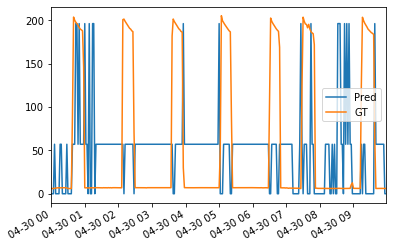

In [42]:
predictions['CO']['Fridge'].head(300).plot(label="Pred")
gt['Fridge'].head(300).plot(label="GT")
plt.legend()

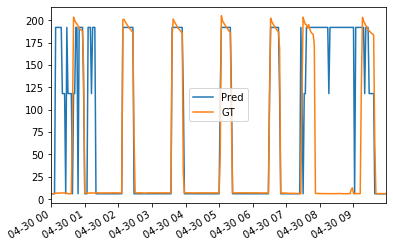

In [43]:
predictions['FHMM']['Fridge'].head(300).plot(label="Pred")
gt['Fridge'].head(300).plot(label="GT")
plt.legend()

## Comparación de algoritmos NILM (CO vs FHMM)
nilmtk.utils.compute_rmse es una extensión de lo siguiente, que maneja mejor tanto los valores perdidos como las etiquetas:
```python
def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)
```

In [44]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = nilmtk.utils.compute_rmse(gt, predictions[clf_name])

rmse = pd.DataFrame(rmse)
rmse

,CO,FHMM
Fridge,102.103477,100.269828
Light,195.132111,73.627119
Sockets,33.279179,37.155416
Microwave,235.322174,545.966517
Dish washer,442.062775,185.935940


# Deducir que es train y test
principal https://github.com/nilmtk/nilmtk/issues/773
Secundario https://github.com/nilmtk/nilmtk/issues/788
De la solución de problemas de nilmtk #773 se hacen las siguientes cuestiones:

**1. ¿Debo entrenar el algoritmo solo en el dispositivo específico que pretendo desagregar?**
    - Esto es lo que más me cuesta entender. ¿Qué medidores debo utilizar en el proceso de formación? ¿Debo usar solo los electrodomésticos que quiero desagregar, todos los electrodomésticos, electrodomésticos y la carga general ...
    
**R/** 
* Debes entrenar en los submedidores.
* Puede utilizar train_elec.submeters().select_top_k(k=5)donde podemos seleccionar los mejores electrodomésticos k según su consumo. Compruebe que al establecer k = 3, no se esté considerando ninguna instancia de UTA.
* Para compararlo correctamente, vea el valor rmse: 
```python
def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = compute_rmse(gt, predictions[clf_name])
rmse = pd.DataFrame(rmse)
rmse
```
**2. ¿Al realizar la desagregación en el conjunto de prueba, ¿debo seleccionar la carga general de la que quiero desagregar la AHU??**

**R/**

* Sí, las pruebas se realizarán en la red (). El objetivo es utilizar el modelo entrenado y predecir el consumo de cada aparato en función del consumo total (se anotará por red)

# Este codigo esta en prueba
Se debe verificar cual es la entrada a los modelos para poder formar un modelo propio para mi modelo.... good look JOSE...

In [ ]:
#Demo
from nilmtk import DataSet

ukdale = DataSet('C:/Users/josel/SmartMeter/UK-Dale.h5')
elec = ukdale.buildings[1].elec
elec.use_alternative_mains()


mains = elec.mains()

mains.load(ac_type='apparent', chunksize=10).__next__()

In [ ]:
elec[1].available_columns()

In [ ]:
#Demo
from nilmtk import DataSet

redd = DataSet('C:\\Users\\josel\\SmartMeter\\OrdenandoTodo\\redd.h5')
elecr = redd.buildings[1].elec
elecr.use_alternative_mains()


mains = elecr.mains()

mains.load(ac_type='apparent', chunksize=10).__next__()

In [ ]:
top_5_train_elec[5].available_columns()

In [ ]:
top_5_train_elec[5].available_power_ac_types()

In [ ]:
top_5_train_elec[5].available_physical_quantities()

In [ ]:
for i, chunk in enumerate(test_elec.mains().load(sample_period=sample_period, ac_type='active')):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

In [ ]:
#####original
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    print("ac_type")
    print(ac_type)
    # "ac_type" varía según el conjunto de datos utilizado.
    # Asegúrese de usar el ac_type correcto antes de usar los parámetros predeterminados en este código.
    for i, chunk in enumerate(test_elec.mains().load(sample_period=sample_period,
                                                     ac_type='active',
                                                     physical_quantity='power')):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(sample_period=sample_period,
                                           ac_type='active',
                                           physical_quantity='power'))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.ix[common_index_local]
    pred_overall = pred_overall.ix[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [ ]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    # "ac_type" varía según el conjunto de datos utilizado.
    # Asegúrese de usar el ac_type correcto antes de usar los parámetros predeterminados en este código.
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [ ]:
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
#train.metadata['timezone'] = 'US/Eastern'
classifiers = {'FHMM':FHMM()}
predictions = {}
sample_period = 30
physical_quantity="power"
ac_type=next(test_elec.mains().load(sample_period=sample_period)).columns.values[0][1]
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    clf.train(top_5_train_elec, sample_period=sample_period)
    gt, predictions[clf_name] = predict(clf, test_elec, 30, train.metadata['timezone'])

In [ ]:
import time
classifiers = {'FHMM':FHMM()}
predictions = {}
sample_period = 30
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(top_5_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

In [ ]:
def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = compute_rmse(gt, predictions[clf_name])
rmse = pd.DataFrame(rmse)
rmse